# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 26th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
import numba
numba.__version__

'0.40.0'

In [2]:
# Change here using YOUR first and last names
fn1 = "hadrien"
ln1 = "piegard"
fn2 = "saphia"
ln2 = "benmansour"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_piegard_hadrien_and_benmansour_saphia.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [3]:
%matplotlib inline

In [4]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit

In [5]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [6]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [7]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [8]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [9]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [10]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

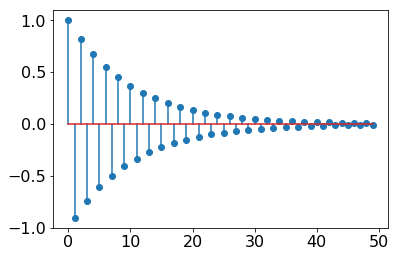

In [11]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [12]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

1.8347401137326392e-06

In [13]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.674105997049145e-07

### Choice of the model

In [14]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [15]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.061785360232950934


### Get a very precise minimum to compute distances to minimum

In [16]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.529209172981698
2.1902563465052472e-08


<a id='batch'></a> 


## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [17]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [18]:
# Number of iterations
n_iter = 50

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [52]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = x - step * grad(x, *args) 
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [53]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [87]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
            
            
        ### TODO
        x_new = y - step * grad(y, *args)
        t_new = (1. + np.sqrt(1 + 4 * t ** 2)) / 2
        y = x_new + (t - 1) / t_new * (x_new - x)
        x, t = x_new, t_new
        ### END TODO
        
    return x, x_list

In [88]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s nonlinear conjuguate gradient solver. First, define a function to run scipy algorithms and return the list of iterates.

In [89]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [90]:
# Nonlinear Conjugate gradient algorithm
from scipy.optimize import fmin_cg

x_init = np.zeros(d)

monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)

         Current function value: 0.529218
         Iterations: 50
         Function evaluations: 80
         Gradient evaluations: 80


### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [91]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [92]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

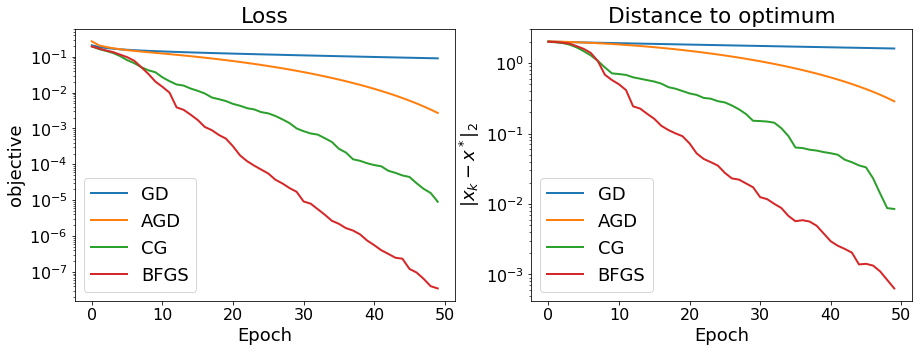

In [93]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs]

solvers = ["GD", "AGD", "CG", "BFGS"]

plot_epochs(monitors, solvers)

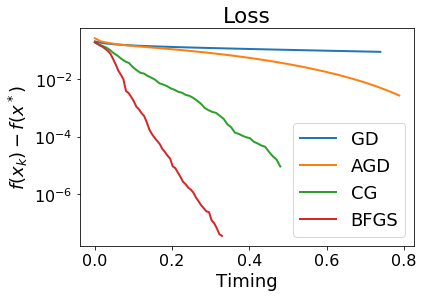

In [94]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about AGD? is it suprising ?

<a id='stoc'></a> 
## 4. Stochastic methods

In [95]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)

print(iis)

[2044 7943 1528 ... 8816 5536 1647]


### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [96]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        
        x -= ( step / (idx + 1)**(1/2) ) * grad_i(i, x, *args)

        ### END TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [97]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [98]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        averaged_gradient -= gradient_memory[i] / n 
        
        gradient_memory[i] = grad_i(i, x, *args)
        
        averaged_gradient += gradient_memory[i] / n 
        
        x = x - step * averaged_gradient
        ### END OF TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [99]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [100]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    for idx in range(n_iter):
        
        ### TODO
        if ( idx % store_every == 0):
            x_t = x.copy()
            m_k = grad( x_t, *args)
            
        i = iis[idx]
        x -= step * (grad_i (i, x, *args) - grad_i(i, x_t, *args) + m_k)
            
        ### END TODO        
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [101]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

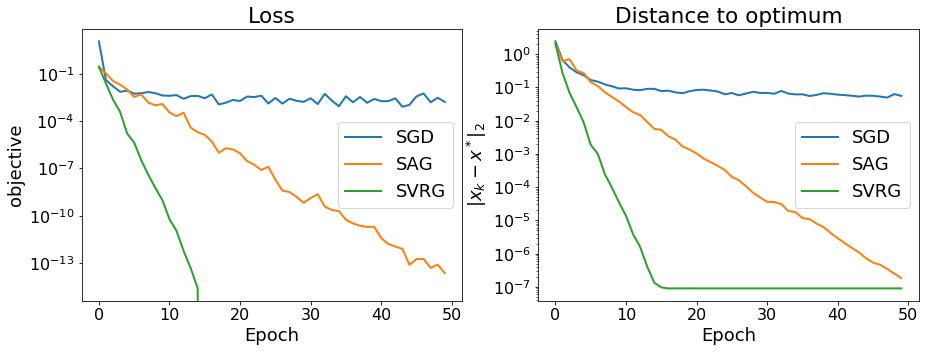

In [102]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

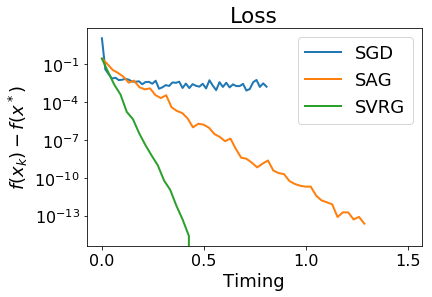

In [103]:
plot_time(monitors, solvers)

<a id='comp'></a> 
## 5. Numerical comparison

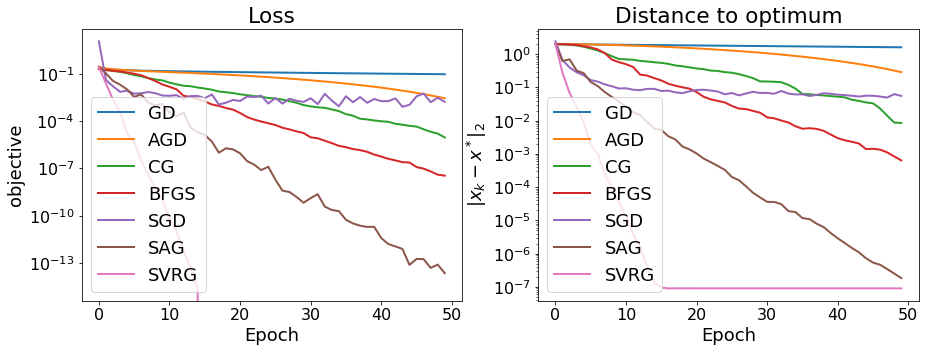

In [104]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

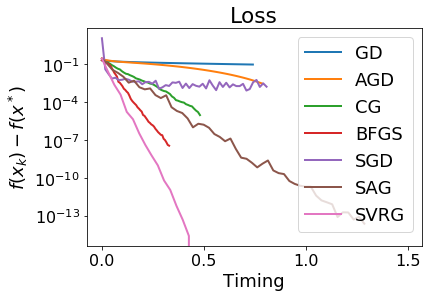

In [105]:
plot_time(monitors, solvers)

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

In [129]:
lbdas = [['1/n**(1/2)', 1./n**(1/2) ], [ '1/n', 1./n],[ '1/n**2', 1./n**2]]
corrs = [0.1, 0.4, 0.6, 0.9]
n_iter = 50

print (lbdas[2][1])

1e-08


In [131]:
#model can be 'lin' or 'log'
def nonstoch_model_eval (lbdas, correl, model = 'lin'):
    
    if model == 'lin':
        A, b = simu_linreg(x_model_truth, n, std=1., corr=correl)
        loss = loss_linreg
        grad = grad_linreg
        grad_i = grad_i_linreg
        lipschitz_constant = lipschitz_linreg
        
    elif model =='log':
        A, b = simu_logreg(x_model_truth, n, std=1., corr=correl)
        loss = loss_logreg
        grad = grad_logreg
        grad_i = grad_i_logreg
        lipschitz_constant = lipschitz_logreg
    
    else :
        print('Non-valid model')
    
    monitors = []
    solvers = []
    
    for i in range (len (lbdas)):
        
        x_init = np.zeros(d)
        x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbdas[i][1]), pgtol=1e-30, factr=1e-30)

        #non-stochastics
        step = 1. / lipschitz_linreg(A, b, lbdas[i][1])
        monitor_gd = monitor(gd, loss, x_min, (A, b ,lbdas[i][1]))
        monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbdas[i][1]))

        step = 1. / lipschitz_linreg(A, b, lbdas[i][1])
        monitor_agd = monitor(agd, loss, x_min, (A, b ,lbdas[i][1]))
        monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbdas[i][1]))

        monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbdas[i][1]))
        monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbdas[i][1]), gtol=1e-9)

        monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbdas[i][1]))
        monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbdas[i][1]), pgtol=1e-30)

        monitors_i = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs]
        solvers_i = ["GD " + lbdas[i][0], "AGD " + lbdas[i][0], "CG " + lbdas[i][0], "BFGS " + lbdas[i][0]]
       
        #stochastics
        step0 = 1e-1
        monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbdas[i][1]))
        monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbdas[i][1]))

        max_squared_sum = np.max(np.sum(A ** 2, axis=1))
        step = 1.0 / (max_squared_sum + lbdas[i][1])
        monitor_sag = monitor(sag, loss, x_min, (A, b ,lbdas[i][1]))
        monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=(A, b, lbdas[i][1]))

        monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbdas[i][1]))
        monitor_svrg.run(x_init, iis, grad, grad_i, n_iter * n, step, args=(A, b, lbdas[i][1]))
        
        monitors_i = [monitor_sgd, monitor_sag, monitor_svrg]
        solvers_i = ["SGD " + lbdas[i][0], "SAG " + lbdas[i][0], "SVRG " + lbdas[i][0]]
        
        

        monitors += monitors_i
        solvers += solvers_i
        
    return monitors, solvers
    

In [122]:
monitors, solvers, = nonstoch_model_eval(lbdas, 0.9, 'lin')
plot_epochs(monitors, solvers)

TypeError: can't multiply sequence by non-int of type 'float'

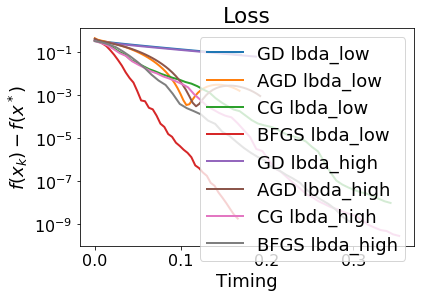

In [109]:
plot_time(monitors, solvers)

         Current function value: 0.495364
         Iterations: 50
         Function evaluations: 77
         Gradient evaluations: 77
         Current function value: 0.519677
         Iterations: 50
         Function evaluations: 82
         Gradient evaluations: 82


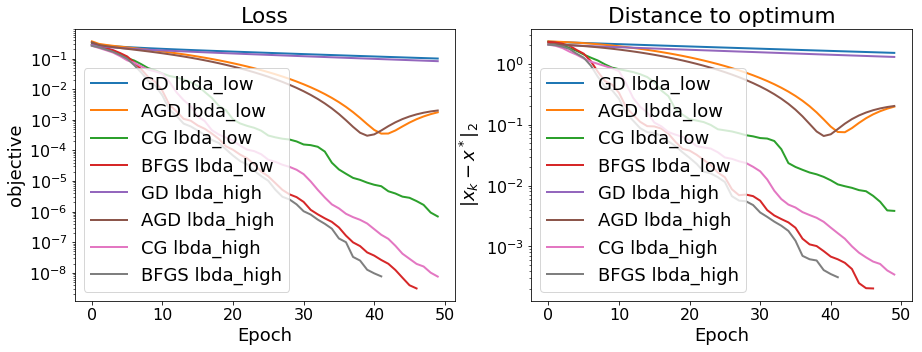

In [110]:
monitors, solvers, = nonstoch_model_eval(lbdas, 0.845)
plot_epochs(monitors, solvers)

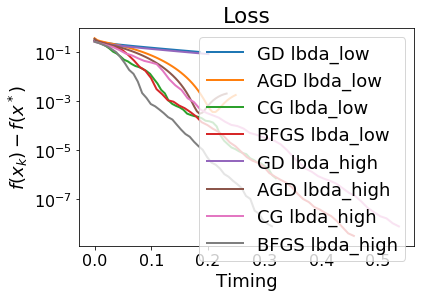

In [111]:
plot_time(monitors, solvers)

In [112]:
n_iter = 50
# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)
print(iis)

[5399 5944 3794 ... 7152 2437 3521]


In [113]:
def stoch_model_eval (lbdas, correl):
    
    A, b = simu_linreg(x_model_truth, n, std=1., corr=correl)
    loss = loss_linreg
    grad = grad_linreg
    grad_i = grad_i_linreg
    lipschitz_constant = lipschitz_linreg
    monitors = []
    solvers = []
    
    for i in range (len (lbdas)):
        
        step = 1. / lipschitz_constant(A, b, lbdas[i][1])

        x_init = np.zeros(d)
        x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbdas[i][1]), pgtol=1e-30, factr=1e-30)

        #stochastic
        step0 = 1e-1
        x_init = np.zeros(d)
        monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbdas[i][1]))
        monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbdas[i][1]))

        max_squared_sum = np.max(np.sum(A ** 2, axis=1))
        step = 1.0 / (max_squared_sum + lbdas[i][1])
        x_init = np.zeros(d)
        monitor_sag = monitor(sag, loss, x_min, (A, b ,lbdas[i][1]))
        monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=(A, b, lbdas[i][1]))

        x_init = np.zeros(d)
        monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbdas[i][1]))
        monitor_svrg.run(x_init, iis, grad, grad_i, n_iter * n, step, args=(A, b, lbdas[i][1]))
        
        monitors_i = [monitor_sgd, monitor_sag, monitor_svrg]
        solvers_i = ["SGD " + lbdas[i][0], "SAG " + lbdas[i][0], "SVRG " + lbdas[i][0]]

        monitors += monitors_i
        solvers += solvers_i
        
    return monitors, solvers
    

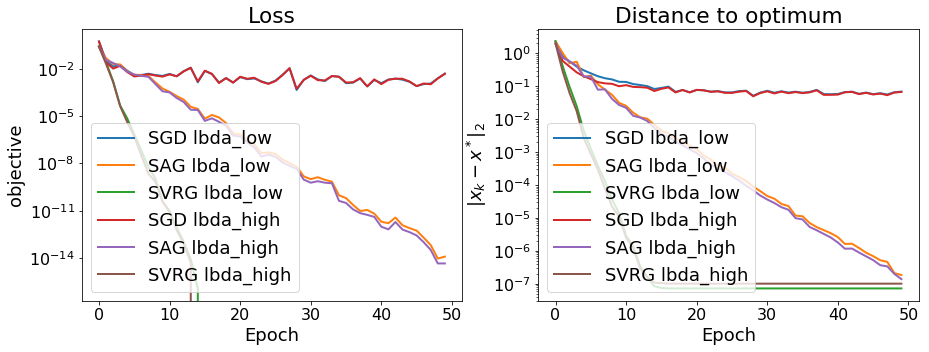

In [114]:
monitors, solvers, = stoch_model_eval(lbdas, 0.9)
plot_epochs(monitors, solvers)

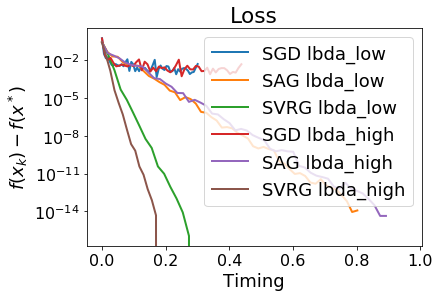

In [115]:
plot_time(monitors, solvers)

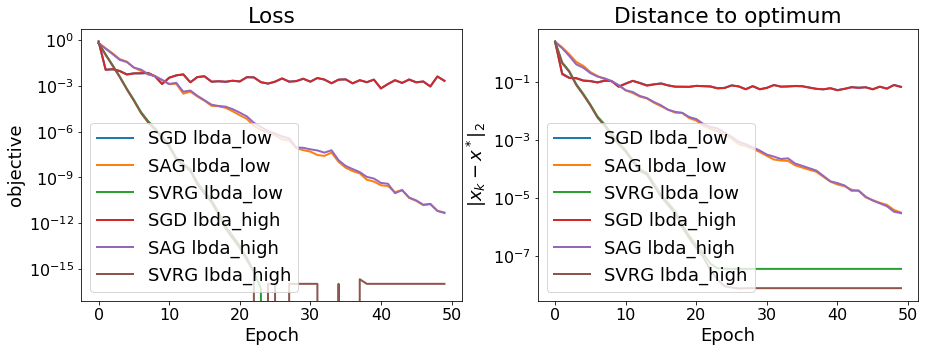

In [116]:
monitors, solvers, = stoch_model_eval(lbdas, 0.7)
plot_epochs(monitors, solvers)

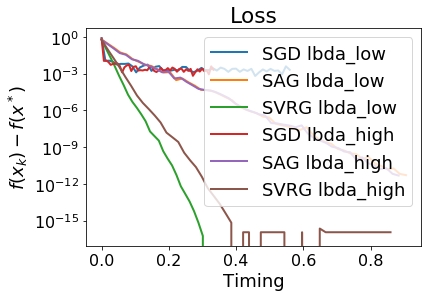

In [117]:
plot_time(monitors, solvers)